## Recommender Engine Using Autoencoder
**Serah Elsa Abraham**

### Import library

In [1]:
import sklearn
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

### Import dataset

In [2]:
amazon_ratings = pd.read_csv('ratings_Electronics.csv',
                     encoding = 'latin-1', names=['userID','ProductID',
                                           'Ratings','Timestamp'])

In [3]:
sample_ratings = amazon_ratings.sample(frac=0.001)


### Exploratory Data Analysis

In [4]:

del amazon_ratings
sample_ratings['productID'] = pd.factorize(sample_ratings['ProductID'])[0]
sample_ratings['UserID'] = pd.factorize(sample_ratings['userID'])[0]
sample_ratings.drop(['userID', 'ProductID'], axis=1, inplace=True)
columns = ['UserID', 'productID', 'Ratings', 'Timestamp']
sample_ratings.reindex(columns = columns)


,UserID,productID,Ratings,Timestamp
593471,0,0,5,1127952000
565636,1,1,5,1339027200
633323,2,2,4,1297555200
862754,3,3,4,1168300800
923827,4,4,1,1358726400
...,...,...,...,...
180208,1044,878,5,1076198400
610432,1045,879,5,1199059200
254471,1046,880,5,1358035200
248705,1047,881,5,1104710400


In [5]:
#print missing value
print(sample_ratings.isna().sum())
print(sample_ratings.isnull().sum())

Ratings      0
Timestamp    0
productID    0
UserID       0
dtype: int64
Ratings      0
Timestamp    0
productID    0
UserID       0
dtype: int64


In [6]:
sample_ratings.describe()

,Ratings,Timestamp,productID,UserID
count,1049.000000,1.049000e+03,1049.000000,1049.000000
mean,3.958055,1.250416e+09,403.487131,524.000000
std,1.397296,1.074902e+08,259.124664,302.964519
min,1.000000,9.485856e+08,0.000000,0.000000
25%,3.000000,1.169856e+09,171.000000,262.000000
50%,5.000000,1.249430e+09,380.000000,524.000000
75%,5.000000,1.356566e+09,627.000000,786.000000
max,5.000000,1.405296e+09,882.000000,1048.000000


In [7]:
sample_ratings.groupby('UserID')['Ratings'].count().sort_values(ascending=False)

UserID
0       1
689     1
691     1
692     1
693     1
       ..
355     1
356     1
357     1
358     1
1048    1
Name: Ratings, Length: 1049, dtype: int64

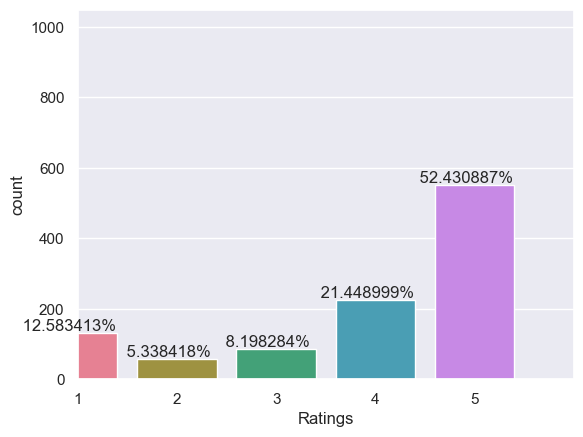

In [8]:

# create the countplot with the specified colors
ax = sns.countplot(data=sample_ratings, x='Ratings', palette="husl")

# set the y-axis limit to be the number of rows in the dataset
ax.set_ylim(0, len(sample_ratings))

# set the x-axis limit to be from 0 to 5
ax.set_xlim(0, 5)

# add text labels above each bar showing the percentage of rows in that bar
for g in ax.patches:
    height = g.get_height()
    ax.text(g.get_x()+g.get_width()/2.75,
            height + 7,
            '{: %}'.format(height/float(len(sample_ratings))),
            ha="center")


Observation : more than 50% of users have rated 5. So we have highest number of 5 ratings.

### Splitting dataset into training_set and test_set

In [9]:
sample_ratings.groupby('productID')['Ratings'].count().sort_values(ascending=False)

productID
22     15
52      7
47      6
30      6
232     6
       ..
335     1
336     1
337     1
338     1
882     1
Name: Ratings, Length: 883, dtype: int64

In [11]:
seed = 42
train_set, test_set = train_test_split(sample_ratings, random_state=seed,test_size=0.2)

### Convert dataset into array

In [12]:

train_set = np.array(train_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

### Getting the total number of users and products

In [13]:

count_users = int(max(max(train_set[:, 3], ), max(test_set[:, 3])))
count_products = int(max(max(train_set[:, 2], ), max(test_set[:, 2])))

### Converting the data into an array with users in lines and products in columns

In [14]:
def transform(data):
  data_list = []
  for id_users in range(1, count_users + 1):
    id_products = data[:, 2] [data[:, 3] == id_users]
    id_ratings = data[:, 1] [data[:, 3] == id_users]
    ratings = np.zeros(count_products)
    ratings[id_products - 1] = id_ratings
    data_list.append(list(ratings))
  return data_list
train_set = transform(train_set)
test_set = transform(test_set)


### Converting the data into Torch tensors

In [15]:
train_set = torch.FloatTensor(train_set)
test_set = torch.FloatTensor(test_set)

### Creating the architecture for the Neural Network

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(count_products, 20)
        self.hidden1 = nn.Linear(20, 10)
        self.hidden2 = nn.Linear(10, 20)
        self.decoder = nn.Linear(20, count_products)
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.activation(self.encoder(x))
        x = torch.relu(x)
        x = self.activation(self.hidden1(x))
        x = torch.relu(x)
        x = self.activation(self.hidden2(x))
        x = torch.relu(x)
        x = self.decoder(x)
        return x

The model also includes an activation function, dropout layer, and optimizer for training.It takes input of size count_products and reduces it to a latent representation of size 20 through several linear and non-linear layers. The latent representation is the output of the encoder network, which encodes the input data into a lower dimensional space. The decoder part of the network then tries to reconstruct the original input from this latent representation. The model also includes a dropout layer with a dropout rate of 0.25.

### Training and testing the Autoencoder
The autoencoder consists of an encoder and a decoder network, with some hidden layers in between. The encoder takes the input data and reduces it to a lower-dimensional representation, and the decoder takes this representation and reconstructs the original input data.

In [30]:
autoencoder = Autoencoder()

criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)


The **MSELoss** class from the nn module is created and assigned to the variable criterion. This is the loss function that will be used to measure the difference between the output of the autoencoder and the input.
The **SGD (Stochastic Gradient Descent) optimizer** is created and assigned to the variable optimizer. The optimizer is responsible for updating the parameters of the autoencoder during training in order to minimize the value of the loss function.
The SGD optimizer uses a stochastic gradient descent algorithm with a fixed learning rate of 0.01, a momentum of 0.9, and a weight decay of 1e-5. The learning rate determines the step size taken in the direction of the gradient during each iteration, while the momentum parameter helps the optimizer overcome local minima and converge faster. The weight decay parameter introduces a penalty term on the size of the weights in order to prevent overfitting.

In [32]:
count_epoch = 100
train_loss_list = []
val_loss_list = []

for epoch in range(1, count_epoch + 1):
    train_loss = 0
    count = 0
    for id_user in range(count_users):
        input = Variable(train_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = autoencoder(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = count_products/float(torch.sum(target.data > 0)+ 1e-10 )
            
            # L2 regularization
            l2_reg = Variable(torch.FloatTensor([0.0]), requires_grad=True)
            for param in autoencoder.parameters():
                l2_reg = l2_reg + torch.norm(param, 2)
            loss = loss + 1e-5 * l2_reg
            
            loss.backward()
            train_loss += np.sqrt(loss.data*mean_corrector)
            count += 1
            optimizer.step()
    
    # Validation loss
    val_loss = 0
    total_count = 0
    for id_user in range(count_users):
        input = Variable(train_set[id_user]).unsqueeze(0)
        target = Variable(test_set[id_user]).unsqueeze(0)
        if torch.sum(target.data > 0) > 0:
            output = autoencoder(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = count_products/float(torch.sum(target.data > 0))
            val_loss += np.sqrt(loss.data*mean_corrector)
            total_count += 1
    
    epoch_train_loss = train_loss/count
    epoch_val_loss = val_loss/total_count
    
    train_loss_list.append(epoch_train_loss)
    val_loss_list.append(epoch_val_loss)
    
    print("Test loss: {:.5f}".format(test_loss.item()/total_count))
    
    # Early stopping
    if epoch > 5 and val_loss_list[-1] > val_loss_list[-2]:
        print("Early stopping at epoch: ", epoch)
        break
        

Test loss: 1254717615.54286
Test loss: 1254717615.54286
Test loss: 1254717615.54286
Test loss: 1254717615.54286
Test loss: 1254717615.54286
Test loss: 1254717615.54286
Early stopping at epoch:  6


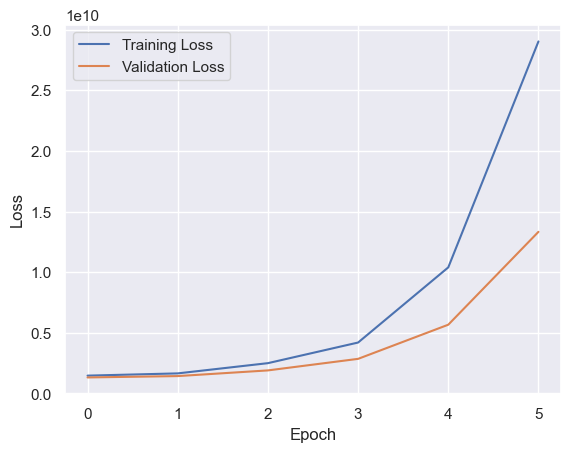

In [34]:
# Plotting the loss graph
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()